In [1]:
import numpy as np
import pandas as pd
import os
import string
import re
import warnings 
warnings.filterwarnings('ignore')

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline

In [4]:
import plotly
import chart_studio.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
from collections import defaultdict
from plotly import tools
from plotly.graph_objs import Scatter, Figure, Layout
cf.set_config_file(offline=True)
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
eng_stopwords = nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.sklearn
from matplotlib import pylab
from pylab import *
import squarify

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
twitter_data = pd.read_csv('auspol2019.csv',parse_dates=['created_at','user_created_at'])
geo_data = pd.read_csv('location_geocode.csv')

In [8]:
twitter_data.head()

created_at                   id  \
0  2019-05-20 09:13:44  1130401208756187136   
1  2019-05-20 09:13:43  1130401205367140357   
2  2019-05-20 09:13:33  1130401162782371841   
3  2019-05-20 09:13:29  1130401143551434753   
4  2019-05-20 09:13:23  1130401118666809345   

                                           full_text  retweet_count  \
0  After the climate election: shellshocked green...            0.0   
1  @narendramodi @smritiirani Coverage of indian ...            0.0   
2  @workmanalice Do you know if Facebook is relea...            0.0   
3  @vanbadham We all understand we have a compuls...            0.0   
4  Shares were mixed in Asia, with India and Aust...            0.0   

   favorite_count       user_id          user_name user_screen_name  \
0             0.0  9.248486e+07       PIPELINEPETE         jocksjig   
1             0.0  7.756474e+08    Narinder Parmar      nparmar1957   
2             0.0  5.687300e+04        Peter Wells       peterwells   
3             0.0  9.081660e+17        The Realist    therealist822   
4             0.0  5.260074e+08  Inquirer Business      InquirerBiz   

                                    user_description  \
0  Retired Tradesman and Progressive Anti Conserv...   
1  Life coach & trainer, Motivational speaker, Ma...   
2  Writes for @theage and @smh on technology and ...   
3  Calls it as I see it. Anti PC, SJW and VS. If ...   
4  The official Twitter account of the Inquirer G...   

                user_location     user_created_at  
0        Brisbane, Queensland 2009-11-25 09:19:45  
1  Wollongong, NSW, AUSTRALIA 2012-08-23 10:20:40  
2                   Melbourne 2006-12-11 07:38:06  
3                         NaN 2017-09-14 03:10:30  
4                 Philippines 2012-03-16 03:51:59

In [9]:
geo_data.head()

name        lat        long
0        Brisbane, Queensland -27.469771  153.025124
1  Wollongong, NSW, AUSTRALIA -34.427812  150.893061
2                   Melbourne -37.813628  144.963058
3                 Philippines  12.879721  121.774017
4                   Australia -25.274398  133.775136

In [10]:
twitter_data.shape

(183379, 11)

In [11]:
geo_data.shape

(11153, 3)

In [12]:
twitter_data = twitter_data.merge(geo_data, how='inner', left_on='user_location', right_on='name')


In [13]:
twitter_data.head()

created_at                   id  \
0  2019-05-20 09:13:44  1130401208756187136   
1  2019-05-20 09:12:57  1130401009782673408   
2  2019-05-20 09:02:04  1130398270813949952   
3  2019-05-20 07:25:41  1130374015103537152   
4  2019-05-20 07:12:01  1130370578584461313   

                                           full_text  retweet_count  \
0  After the climate election: shellshocked green...            0.0   
1  It is disappointing that @tanya_plibersek has ...            0.0   
2  'Vote for the climate': NSW demands environmen...            0.0   
3  This is urgent! “False election claims spark p...            0.0   
4  This is a great piece, not least because it pl...            0.0   

   favorite_count       user_id       user_name user_screen_name  \
0             0.0  9.248486e+07    PIPELINEPETE         jocksjig   
1             0.0  5.100258e+07  Matthew Rimmer         DrRimmer   
2             0.0  9.248486e+07    PIPELINEPETE         jocksjig   
3             0.0  3.327641e+08         E Ferri         eneferri   
4             2.0  2.180023e+09  Shahar Hameiri    ShaharHameiri   

                                    user_description         user_location  \
0  Retired Tradesman and Progressive Anti Conserv...  Brisbane, Queensland   
1  Professor of IP & Innovation Law @QUTLaw @QUT_...  Brisbane, Queensland   
2  Retired Tradesman and Progressive Anti Conserv...  Brisbane, Queensland   
3  Writer, researcher, educator in media, adverti...  Brisbane, Queensland   
4  Associate Professor @polsisengage @UQ_news. Po...  Brisbane, Queensland   

      user_created_at                  name        lat        long  
0 2009-11-25 09:19:45  Brisbane, Queensland -27.469771  153.025124  
1 2009-06-26 10:17:54  Brisbane, Queensland -27.469771  153.025124  
2 2009-11-25 09:19:45  Brisbane, Queensland -27.469771  153.025124  
3 2011-07-10 11:20:43  Brisbane, Queensland -27.469771  153.025124  
4 2013-11-07 12:39:24  Brisbane, Queensland -27.469771  153.025124

In [14]:
twitter_data = twitter_data.drop('name',axis =1)

In [15]:
twitter_data.isnull().mean()*100

created_at          0.000000
id                  0.000000
full_text           0.000000
retweet_count       0.000000
favorite_count      0.000000
user_id             0.000000
user_name           0.000000
user_screen_name    0.000000
user_description    4.115822
user_location       0.000000
user_created_at     0.000000
lat                 0.000000
long                0.000000
dtype: float64

In [16]:
print(f" Data Available since {twitter_data.created_at.min()}")
print(f" Data Available upto {twitter_data.created_at.max()}")

 Data Available since 2019-05-10 16:58:15
 Data Available upto 2019-05-20 11:40:07


In [17]:
#lets check latest and oldest twitter members in the dataframe
print(f" Data Available since {twitter_data.user_created_at.min()}")
print(f" Data Available upto {twitter_data.user_created_at.max()}")

 Data Available since 2006-03-21 21:04:12
 Data Available upto 2019-05-19 10:49:59


In [18]:
print('The oldest user in the data was',twitter_data.loc[twitter_data['user_created_at'] == '2006-03-21 21:04:12', 'user_name'].values)

The oldest user in the data was ['rabble']


In [19]:
print('The newest user in the data was',twitter_data.loc[twitter_data['user_created_at'] == '2019-05-19 10:49:59', 'user_name'].values)


The newest user in the data was ['NewsaCol®️']


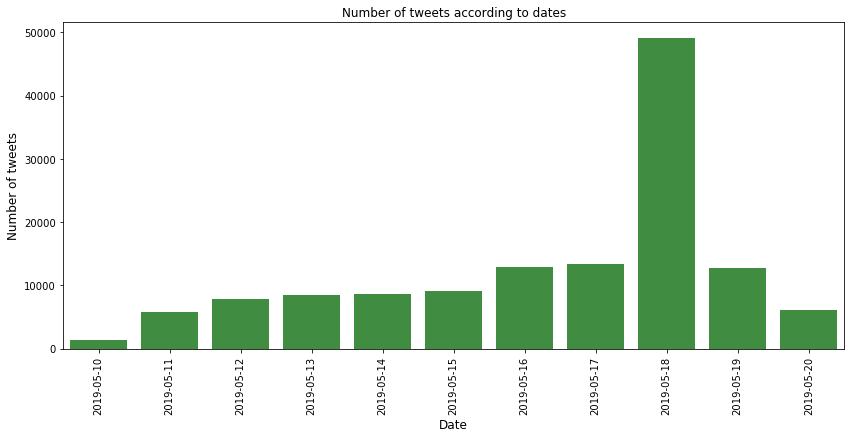

In [20]:
#lets explore created_at column
twitter_data['created_at'] =  pd.to_datetime(twitter_data['created_at'])
cnt_srs = twitter_data['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.title("Number of tweets according to dates")
plt.show()

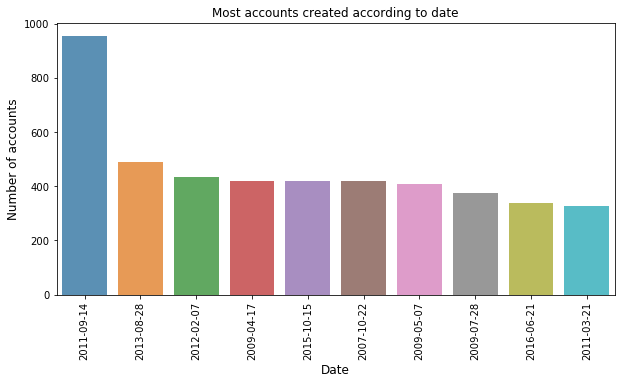

In [21]:
#lets explore user_created_at column
count_  = twitter_data['user_created_at'].dt.date.value_counts()
count_ = count_[:10,]
plt.figure(figsize=(10,5))
sns.barplot(count_.index, count_.values, alpha=0.8)
plt.title('Most accounts created according to date')
plt.xticks(rotation='vertical')
plt.ylabel('Number of accounts', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

In [22]:
#lets derive some columns from date colums
twitter_data['tweeted_day_of_week'] = twitter_data['created_at'].dt.weekday_name
twitter_data['created_day_of_week'] = twitter_data['user_created_at'].dt.weekday_name


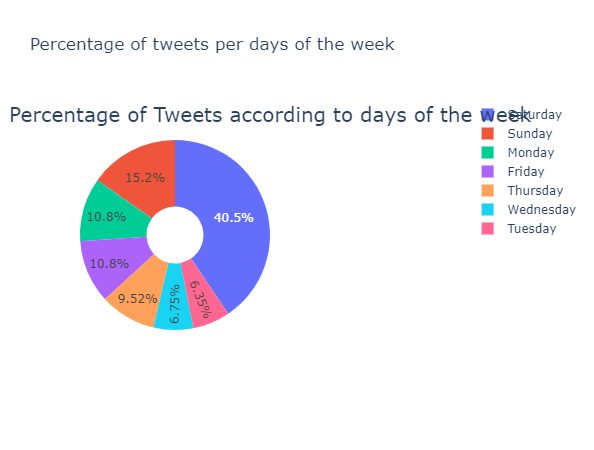

Friday       14622
Monday       14651
Saturday     54879
Sunday       20598
Thursday     12891
Tuesday       8600
Wednesday     9139
Name: tweeted_day_of_week, dtype: int64

In [23]:
cnt_ = twitter_data['tweeted_day_of_week'].value_counts()
cnt_ = cnt_.sort_index() 
fig = {
  "data": [
    {
      "values": cnt_.values,
      "labels": cnt_.index,
      "domain": {"x": [0, .5]},
      "name": "Number of tweets per day",
      "hoverinfo":"label+percent+name",
      "hole": .3,
      "type": "pie"
    },],
  "layout": {
        "title":"Percentage of tweets per days of the week",
        "annotations": [
            { "font": { "size": 20},
              "showarrow": False,
             "text": "Percentage of Tweets according to days of the week",
                "x": 0.50,
                "y": 1
            },
        ]
    }
}
iplot(fig)
cnt_

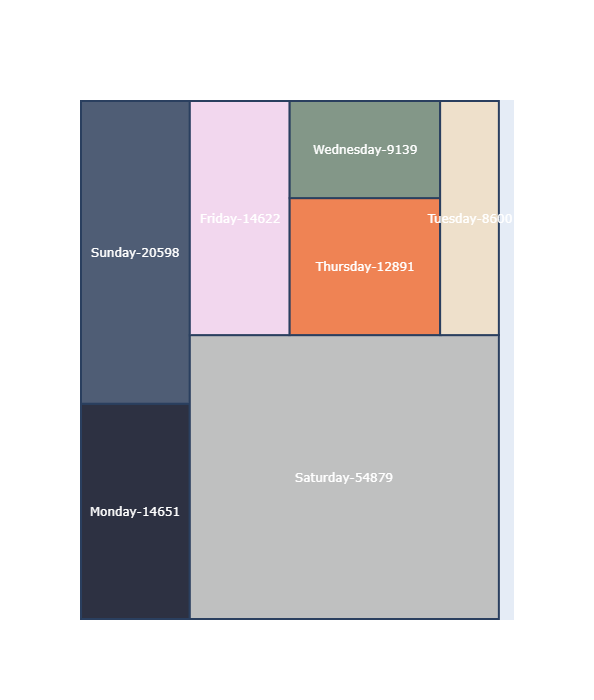

In [24]:
x = 0.
y = 0.
width = 50.
height = 50.
type_list = list(twitter_data['tweeted_day_of_week'].unique())
values = [len(twitter_data[twitter_data['tweeted_day_of_week'] == i]) for i in type_list]

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

color_brewer = ['#2D3142','#4F5D75','#BFC0C0','#F2D7EE','#EF8354','#839788','#EEE0CB']
shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append( 
        dict(
            type = 'rect', 
            x0 = r['x'], 
            y0 = r['y'], 
            x1 = r['x']+r['dx'], 
            y1 = r['y']+r['dy'],
            line = dict( width = 2 ),
            fillcolor = color_brewer[counter]
        ) 
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = "{}-{}".format(type_list[counter], values[counter]),
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(color_brewer):
        counter = 0

# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects ], 
    y = [ r['y']+(r['dy']/2) for r in rects ],
    text = [ str(v) for v in values ], 
    mode = 'text',
)
        
layout = dict(
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest',
    font=dict(color="#FFFFFF")
)

# With hovertext
figure = dict(data=[trace0], layout=layout)
iplot(figure, filename='squarify-treemap')

In [25]:
#lets extract the hours from the created_at and user_created_at column
twitter_data['created_at_hour'] = twitter_data['created_at'].dt.hour
twitter_data['user_created_at_hour'] = twitter_data['user_created_at'].dt.hour

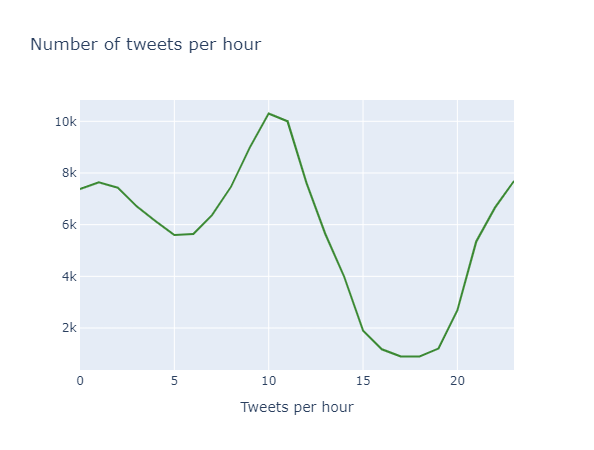

In [26]:
cnt_ = twitter_data['created_at_hour'].value_counts()
cnt_ = cnt_.sort_index() 
trace1 = go.Scatter(
                    x = cnt_.index,
                    y = cnt_.values,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)')
                    )

data = [trace1]
layout = dict(title = 'Number of tweets per hour',
              xaxis= dict(title= 'Tweets per hour',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)


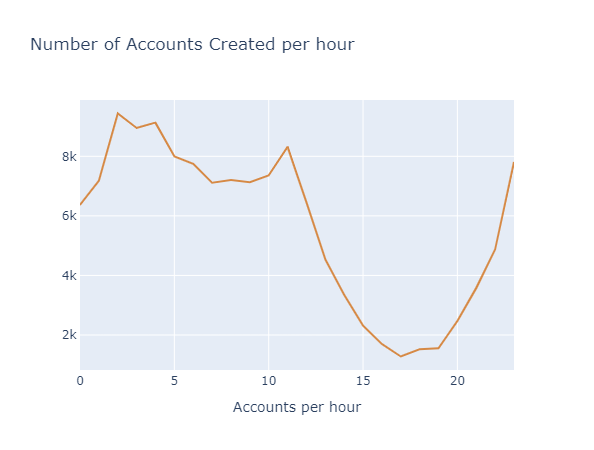

In [27]:
cnt_ = twitter_data['user_created_at_hour'].value_counts()
cnt_ = cnt_.sort_index() 
trace1 = go.Scatter(
                    x = cnt_.index,
                    y = cnt_.values,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(210, 113, 25, 0.8)')
                    )

data = [trace1]
layout = dict(title = 'Number of Accounts Created per hour ',
              xaxis= dict(title= 'Accounts per hour',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)


In [30]:
#most favourite and retweeted tweet
print(f" Maximum number of retweets {twitter_data.retweet_count.max()}")
#lets see the tweet which has the maximum retweet count
twitter_data.loc[twitter_data['retweet_count']==6622.0,'full_text'].values
(f" Maximum number of favorites {twitter_data.favorite_count.max()}")#lets see the tweet which has the maximum retweet count


 Maximum number of retweets 6622.0


' Maximum number of favorites 15559.0'

In [31]:
#lets see the tweet which has the maximum retweet count
twitter_data.loc[twitter_data['retweet_count']==6622.0,'full_text'].values

array(["Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd"],
      dtype=object)

In [32]:
twitter_data.loc[twitter_data['favorite_count']==15559.0,['full_text','user_name','user_description']].values

array([["Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd",
        'Sara A. Carter',
        '@FoxNews Contributor, award winning National Security/War Correspondent. @IWF Fellow. Taking back the story. Follow me on Instagram ScarterDC']],
      dtype=object)

In [33]:
#most number of occurances of a person
twitter_data.user_name.value_counts()[:5,]

💧 Sur Plus               937
PM of Australia News     464
🌹MsRose🌹                 415
🍌Leftie Troublemaker🍍    386
Jackie Moss ☔️           300
Name: user_name, dtype: int64

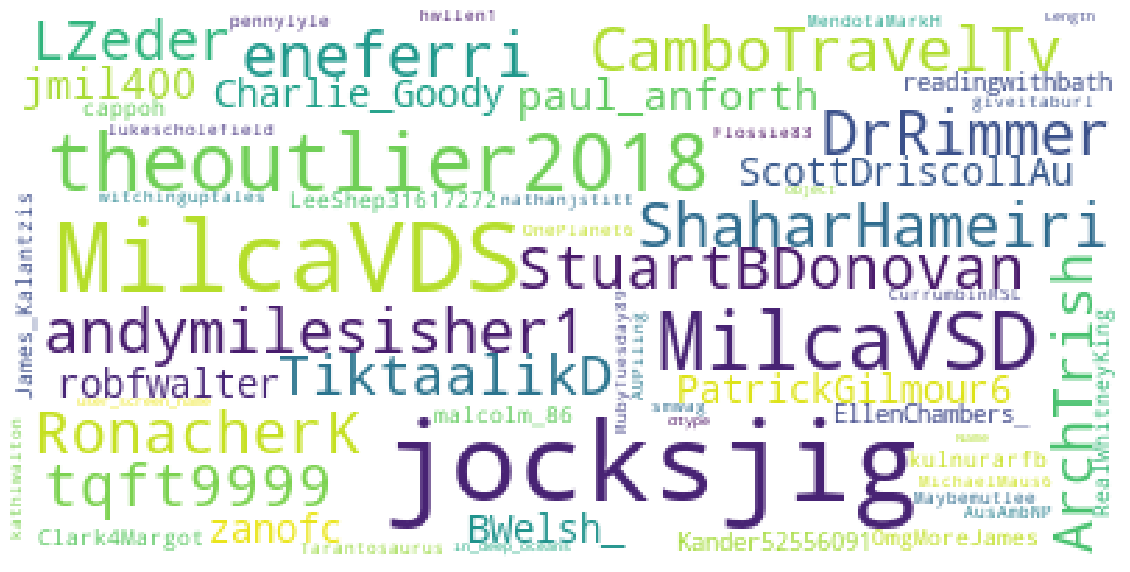

In [34]:
#wordcloud

wordcloud__ = WordCloud(
                          background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=250,
                          max_font_size=40, 
                          random_state=1705
                         ).generate(str(twitter_data['user_screen_name'].dropna()))
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
cloud_plot(wordcloud__)

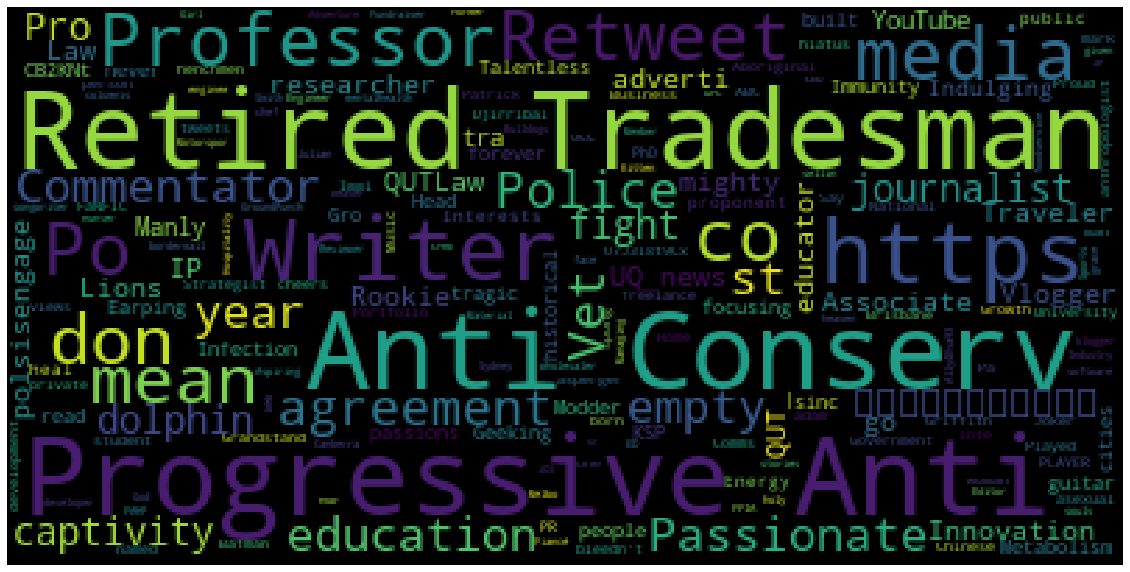

In [35]:
wordcloud_ = WordCloud(
                          background_color='black',
                          stopwords=set(STOPWORDS),
                          max_words=250,
                          max_font_size=40, 
                          random_state=1705
                         ).generate(str(twitter_data['user_description'].dropna()))
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
cloud_plot(wordcloud_)

In [36]:
twitter_data['sentiment'] = twitter_data['full_text'].map(lambda text: TextBlob(text).sentiment.polarity)


In [37]:
print("5 random tweets with highest positive sentiment polarity: \n")
cL = twitter_data.loc[twitter_data.sentiment==1, ['full_text']].sample(5).values
for c in cL:
    print(c[0])
    print()

5 random tweets with highest positive sentiment polarity: 

@AusLabourPrty have said they will &amp; have the superb elder Pat Dodson as Minister #ausvotes #auspol https://t.co/4yDATMeAW5

Sunday 12 May - Cake by @EmilieCollyer
Who doesn't want their piece of it? What's a rhetorical question?
#auspol #ausvote2019 #playwriting #electiondrama
Follow us for a play a day by some of Melbourne's best dramatists during #ausvotes https://t.co/ldt96WxLaj

Ok..having been living out of Australia for so long..no-one bothered to tell me that the Barnaby Joyce twitter account is almost as funny as Donalds!! WTH??!!
I had to check it wasnt a parody account!!

I think BJ might drink.....

....ALOT!!
@theprojecttv #theprojecttv #Auspol https://t.co/kxu9jckmjg

Awesome. #auspol #bbq https://t.co/6VEzNGLbxk

Our best hope now is for a minority government. #auspol #ausvotes https://t.co/hrmKfvC5wc



In [38]:
print("5 random tweets with highest nagative sentiment polarity: \n")
cL = twitter_data.loc[twitter_data.sentiment==-1, ['full_text']].sample(5).values
for c in cL:
    print(c[0])
    print()

5 random tweets with highest nagative sentiment polarity: 

@alexbhturnbull Says the unremarkable son of Australia's worst ever Prime Minister

And you are a bit of a grub as well

Must by why @drkerrynphelps @juliabanksmp &amp; @_Oliver_Yates keep on accepting your money

#auspol https://t.co/NdpTQQK4Kt

God you're a nasty piece of work. #auspol https://t.co/sH8wrUJD7J

This is like the worst Oscar acceptance speech ever @ScottMorrisonMP Where's the orchestra when you need it? #auspol

Please Australia. When you walk into the polling booth. Keep this in mind. Palmer calling the shots would be a truly awful outcome for all of us. Let’s not let it happen. #auspol #ausvotes19 https://t.co/r2j0Ry5aIW

I bet someone is a miserable ghost tonight. And his son.#ausvotes https://t.co/tWGFbAH0BB



In [39]:
print("5 random tweets with neutral sentiment polarity: \n")
cL = twitter_data.loc[twitter_data.sentiment==0, ['full_text']].sample(5).values
for c in cL:
    print(c[0])
    print()

5 random tweets with neutral sentiment polarity: 

I went to bed with hope and faith and woke to my country throwing itself into the coal fire. #AusVotes

#ausvotes Blair electorate still close with 27% of votes still to be counted. Could be a bit of a wait ...
https://t.co/oiaC7nxDoW https://t.co/cWkx7SH5QZ

I think this is closer to the mark #AusVotes2019 #auspol https://t.co/xFltnVLlqY

Federal election 2019: Bill Shorten gets rockstar reception as Clive Palmer heads to Fiji - Australia Votes - Federal Election 2019 - Politics https://t.co/4vYNrhtlPd https://t.co/qPBahjZ94o

The #ausvotes speeches are the boringest, just give me the stats please.



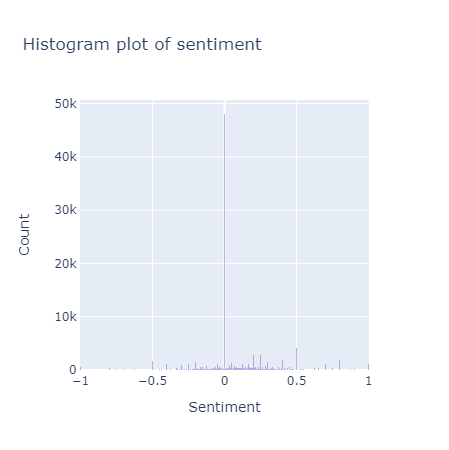

In [40]:
trace1 = go.Histogram(
    x = twitter_data['sentiment'],
    opacity=0.75,
    name = "Sentiment",
    marker=dict(color='rgba(122, 75, 196, 0.6)'))

data = [trace1]
layout = go.Layout(barmode='overlay',
                   title='Histogram plot of sentiment',
                   xaxis=dict(title='Sentiment'),
                   yaxis=dict( title='Count'),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [41]:
cut = pd.cut(
    twitter_data['sentiment'],
    [-np.inf, -.01, .01, np.inf],
    labels=['negative', 'neutral', 'positive']
)
twitter_data['polarity'] = cut.values
twitter_data[['polarity','sentiment']][:20]


polarity  sentiment
0   negative  -0.200000
1   negative  -0.600000
2    neutral   0.000000
3   negative  -0.200000
4   negative  -0.035714
5   positive   0.500000
6   positive   0.136364
7   positive   0.050000
8   positive   0.300000
9   positive   0.200000
10   neutral   0.000000
11  negative  -0.250000
12  positive   0.366667
13   neutral  -0.002222
14  positive   0.500000
15   neutral   0.000000
16   neutral   0.000000
17  negative  -0.266667
18  positive   0.125000
19   neutral   0.000000

In [42]:
twitter_data['polarity'].value_counts()

positive    58448
neutral     48831
negative    28101
Name: polarity, dtype: int64

In [44]:
twitter_data['count_sent']=twitter_data["full_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)


In [45]:
#Word count in each comment:
twitter_data['count_word']=twitter_data["full_text"].apply(lambda x: len(str(x).split()))


In [46]:
#Unique word count
twitter_data['count_unique_word']=twitter_data["full_text"].apply(lambda x: len(set(str(x).split())))


In [47]:
#Letter count
twitter_data['count_letters']=twitter_data["full_text"].apply(lambda x: len(str(x)))


In [48]:
#punctuation count
twitter_data["count_punctuations"] =twitter_data["full_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


In [49]:
#upper case words count
twitter_data["count_words_upper"] = twitter_data["full_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


In [51]:
#title case words count
twitter_data["count_words_title"] = twitter_data["full_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


In [53]:
#Number of stopwords
eng_stopwords = nltk.download('stopwords')
twitter_data["count_stopwords"] = twitter_data["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TypeError: argument of type 'bool' is not iterable

In [54]:
twitter_data["mean_word_len"] = twitter_data["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [55]:
twitter_data.describe().T


count          mean           std         min  \
retweet_count         135380.0  4.063806e+00  4.038760e+01    0.000000   
favorite_count        135380.0  1.205471e+01  1.275849e+02    0.000000   
user_id               135380.0  1.570645e+17  3.525078e+17   22.000000   
lat                   135380.0 -2.018124e+01  2.755893e+01  -82.862752   
long                  135380.0  1.106561e+02  7.855528e+01 -175.198242   
created_at_hour       135380.0  9.892251e+00  6.836245e+00    0.000000   
user_created_at_hour  135380.0  9.218415e+00  6.749257e+00    0.000000   
sentiment             135380.0  7.946320e-02  2.815131e-01   -1.000000   
count_sent            135380.0  1.850266e+00  1.859723e+00    1.000000   
count_word            135380.0  2.335182e+01  1.313643e+01    1.000000   
count_unique_word     135380.0  2.176205e+01  1.150962e+01    1.000000   
count_letters         135380.0  1.611169e+02  7.983896e+01    7.000000   
count_punctuations    135380.0  9.504277e+00  5.329207e+00    0.000000   
count_words_upper     135380.0  7.221303e-01  1.651610e+00    0.000000   
count_words_title     135380.0  3.535109e+00  2.867331e+00    0.000000   
mean_word_len         135380.0  6.583209e+00  2.335292e+00    1.933333   

                               25%           50%           75%           max  
retweet_count         0.000000e+00  0.000000e+00  1.000000e+00  6.622000e+03  
favorite_count        0.000000e+00  1.000000e+00  4.000000e+00  1.555900e+04  
user_id               7.356489e+07  3.675327e+08  2.590368e+09  1.130063e+18  
lat                  -3.528094e+01 -3.292827e+01 -2.527440e+01  9.000000e+01  
long                  1.337751e+02  1.449631e+02  1.512093e+02  1.784501e+02  
created_at_hour       4.000000e+00  9.000000e+00  1.300000e+01  2.300000e+01  
user_created_at_hour  4.000000e+00  8.000000e+00  1.300000e+01  2.300000e+01  
sentiment             0.000000e+00  0.000000e+00  2.000000e-01  1.000000e+00  
count_sent            1.000000e+00  1.000000e+00  2.000000e+00  4.500000e+01  
count_word            1.300000e+01  2.100000e+01  3.300000e+01  9.800000e+01  
count_unique_word     1.200000e+01  2.000000e+01  3.100000e+01  9.400000e+01  
count_letters         9.700000e+01  1.480000e+02  2.260000e+02  9.690000e+02  
count_punctuations    6.000000e+00  9.000000e+00  1.200000e+01  9.100000e+01  
count_words_upper     0.000000e+00  0.000000e+00  1.000000e+00  5.200000e+01  
count_words_title     2.000000e+00  3.000000e+00  5.000000e+00  4.700000e+01  
mean_word_len         5.222222e+00  6.000000e+00  7.166667e+00  1.290000e+02

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotly/basedatatypes.py:1839: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




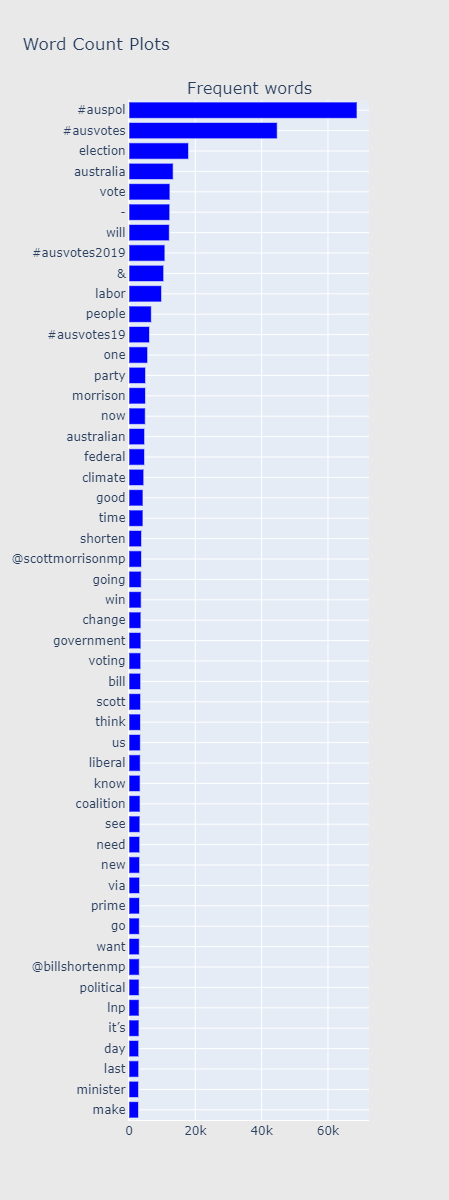

In [56]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


freq_dict = defaultdict(int)
for sent in twitter_data["full_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')


fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"
                                          ])
fig.append_trace(trace0, 1, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots.html')

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotly/basedatatypes.py:1839: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




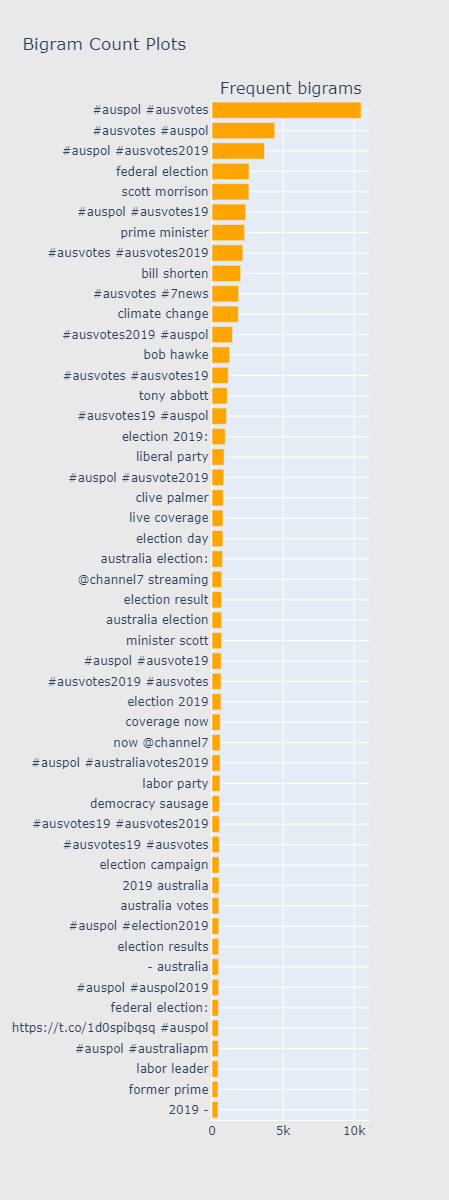

In [57]:
freq_dict = defaultdict(int)
for sent in twitter_data["full_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams"
                                          ])
fig.append_trace(trace0, 1, 1)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
iplot(fig, filename='word-plots')

In [72]:
import chart_studio
chart_studio.tools.set_credentials_file(username='DeveloperAccount', api_key='UTRbfVf8u45DBzYHe1J1tFKsO')
chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')


In [73]:
freq_dict = defaultdict(int)

for sent in twitter_data["full_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams", 
                                          ])
fig.append_trace(trace0, 1, 1)
fig['layout'].update(height=1200, width=1500, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/srv/conda/envs/notebook/lib/python3.7/site-packages/plotly/basedatatypes.py:1839: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




PlotlyRequestError: No such user

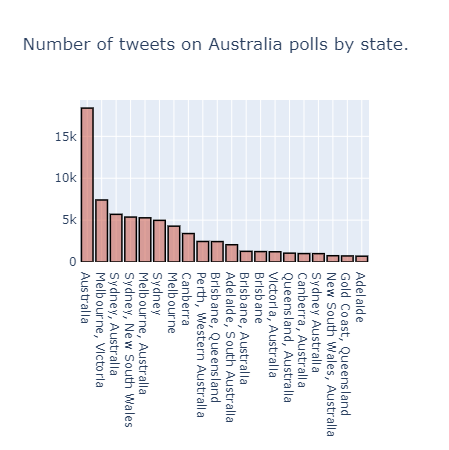

In [61]:
cnt_ = twitter_data['user_location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets on Australia polls by state.",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets on Australia polls by state.')
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [70]:
data = [go.Scattermapbox(
            lat= twitter_data['lat'] ,
            lon= twitter_data['long'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'orange',
                opacity = .8,
            ),
          )]
layout = go.Layout(
    title = go.layout.Title(
        text = 'Tweets on Australia polls by state'
    ),
    geo = go.layout.Geo(
        scope = 'world',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'),
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'd3-cloropleth')

PlotlyRequestError: Authentication credentials were not provided.

In [ ]:
trace1 = go.Scattermapbox(
            lat= twitter_data.loc[twitter_data['polarity'] == 'negative','lat'] ,
            lon= twitter_data.loc[twitter_data['polarity'] == 'negative','long'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'black',
                opacity = .5,
            ),
          )
trace2= go.Scattermapbox(
            lat= twitter_data.loc[twitter_data['polarity'] == 'neutral','lat'] ,
            lon= twitter_data.loc[twitter_data['polarity'] == 'neutral','long'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'blue',
                opacity = .3,
            ),
          )
trace3= go.Scattermapbox(
            lat= twitter_data.loc[twitter_data['polarity'] == 'positive','lat'] ,
            lon= twitter_data.loc[twitter_data['polarity'] == 'positive','long'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'gold',
                opacity = .2,
            ),
          )


data = [trace1,trace2,trace3]
layout = go.Layout(
    title = go.layout.Title(
        text = 'Tweets on Australia polls according to polarity by state '
    ),
    geo = go.layout.Geo(
        scope = 'world',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(200, 125, 255)'),
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'd3-cloropleth-ma')


In [74]:
vectorizer_ = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
tweets_vectorized = vectorizer_.fit_transform(twitter_data['full_text'])

<>:1: DeprecationWarning:

invalid escape sequence \-

<>:1: DeprecationWarning:

invalid escape sequence \-

<>:1: DeprecationWarning:

invalid escape sequence \-

<ipython-input-74-2228b145da40>:1: DeprecationWarning:

invalid escape sequence \-



In [75]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [77]:
lda_ = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
tweets_lda = lda_.fit_transform(tweets_vectorized)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


In [78]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 


In [79]:
print("Tweets LDA Model:")
selected_topics(lda_, vectorizer_)

Tweets LDA Model:
Topic 0:
[('https', 27557.974255289377), ('ausvotes', 27396.436123051906), ('auspol', 25032.94141874725), ('election', 3188.447556562991), ('political', 2949.793707382195), ('democracysausage', 2551.1777872398507), ('abcnews', 1848.0271780160917), ('day', 1786.9482592262152), ('time', 1781.9777245047592), ('coverage', 1653.164779840777)]
Topic 1:
[('https', 14703.43134686789), ('ausvotes', 9936.471575581936), ('auspol', 9586.376801739123), ('election', 9565.5544332861), ('australia', 6934.195799285286), ('news', 6388.879943905673), ('shorten', 5238.8163615727135), ('australiavotes', 4281.632875847881), ('ausvote', 3982.226708267269), ('results', 3364.6915492633248)]
Topic 2:
[('auspol', 9329.95197679213), ('ausvotes', 6578.351693698791), ('https', 4034.2492436766906), ('campaign', 3619.0573441547253), ('know', 2342.604777920937), ('new', 2165.9916171202967), ('just', 1714.3763545743873), ('need', 1574.888740198821), ('think', 1422.5165636410725), ('days', 1378.0466603

In [81]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_, tweets_vectorized, vectorizer_, mds='tsne')
dash


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      501.358795   45.122562       1        1  12.864990
1      176.147568   84.737465       2        1  11.962065
0      -85.378273 -476.740112       3        1  11.559409
8      -34.712917 -156.500793       4        1  10.253758
5     -460.714478  210.233566       5        1   9.871762
3     -138.157730  146.825409       6        1   9.446969
2     -384.665070 -173.287857       7        1   9.404146
6     -115.017181  479.537476       8        1   8.673277
4      293.791870 -291.439514       9        1   8.644331
9      257.326477  409.524445      10        1   7.319293, topic_info=      Category          Freq             Term         Total  loglift  logprob
8180   Default  77749.000000            https  77749.000000  30.0000  30.0000
1254   Default  69690.000000         ausvotes  69690.000000  29.0000  29.0000
5508   Default  27764.000000         election  27764.000000  28.0000  28.0000
18719  Default  15646.000000             vote  15646.000000  27.0000  27.0000
9592   Default  14337.000000            labor  14337.000000  26.0000  26.0000
1217   Default  26072.000000        australia  26072.000000  25.0000  25.0000
1185   Default  88391.000000           auspol  88391.000000  24.0000  24.0000
640    Default  11553.000000              amp  11553.000000  23.0000  23.0000
11204  Default   6710.000000         morrison   6710.000000  22.0000  22.0000
11614  Default   6391.000000             news   6391.000000  21.0000  21.0000
3191   Default   4951.000000          climate   4951.000000  20.0000  20.0000
2848   Default   4916.000000           change   4916.000000  19.0000  19.0000
15699  Default   5241.000000          shorten   5241.000000  18.0000  18.0000
19159  Default   4909.000000              win   4909.000000  17.0000  17.0000
12650  Default   7776.000000           people   7776.000000  16.0000  16.0000
12473  Default   6457.000000            party   6457.000000  15.0000  15.0000
1240   Default   5578.000000   australiavotes   5578.000000  14.0000  14.0000
10993  Default   3574.000000         minister   3574.000000  13.0000  13.0000
7320   Default   4920.000000             good   4920.000000  12.0000  12.0000
1976   Default   3297.000000              bob   3297.000000  11.0000  11.0000
2529   Default   3640.000000         campaign   3640.000000  10.0000  10.0000
3286   Default   4347.000000        coalition   4347.000000   9.0000   9.0000
7794   Default   3187.000000            hawke   3187.000000   8.0000   8.0000
1251   Default   4873.000000          ausvote   4873.000000   7.0000   7.0000
9999   Default   6812.000000             like   6812.000000   6.0000   6.0000
5091   Default   6106.000000              don   6106.000000   5.0000   5.0000
13368  Default   3094.000000            prime   3094.000000   4.0000   4.0000
15250  Default   4676.000000  scottmorrisonmp   4676.000000   3.0000   3.0000
15243  Default   3671.000000            scott   3671.000000   2.0000   2.0000
14533  Default   3367.000000          results   3367.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
12463  Topic10   1885.828164          parties   1886.730609   2.6142  -4.2110
13622  Topic10   1758.564075           public   1759.466486   2.6141  -4.2808
5408   Topic10   1339.667970          economy   1340.570374   2.6140  -4.5529
1472   Topic10   1276.372197          barnaby   1277.274562   2.6139  -4.6013
17466  Topic10   1270.983204          thought   1271.885662   2.6139  -4.6055
13764  Topic10   1100.960384           qldpol   1101.862840   2.6138  -4.7491
18032  Topic10   1092.982689          twitter   1093.885114   2.6138  -4.7564
15653  Topic10   1089.799372             shit   1090.701811   2.6138  -4.7593
9221   Topic10    986.524014            joyce    987.426374   2.6137  -4.8589
13804  Topic10    946.681225         question    947.583666   2